In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage, RandomResizedCrop, RandomHorizontalFlip

In [25]:
class FvsKvsM(Dataset):
    def __init__(self, root, train=True, transform=None):
        super().__init__()
        self.image_paths = []
        self.labels = []
        self.categories = ["female", "kid", "male"]
        self.transform = transform

        if train:
            data_path = os.path.join(root, 'train')
        else:
            data_path = os.path.join(root, 'test')

        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path,category)
            for item in os.listdir(data_files):
                path = os.path.join(data_files,item)
                self.image_paths.append(path)
                self.labels.append(i)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [27]:
class VVG16_net(nn.Module):
    def __init__(self, in_channels=3, n_classes=3):
        super().__init__()
        self.in_channels = in_channels
        self.conv1 = self.conv_block(in_channels=self.in_channels, block=[64, 64])
        self.conv2 = self.conv_block(in_channels=64, block=[128, 128])
        self.conv3 = self.conv_block(in_channels=128, block=[256, 256, 256])
        self.conv4 = self.conv_block(in_channels=256, block=[512, 512, 512])
        self.conv5 = self.conv_block(in_channels=512, block=[512, 512, 512])
        self.fcs = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fcs(x)
        return x

    def conv_block(self, in_channels ,block):
        layers = []
        for i in block:
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=i, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                       nn.BatchNorm2d(i),
                       nn.ReLU()]
            in_channels = i
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        return nn.Sequential(*layers)

In [29]:
train_dataset = FvsKvsM(root= root, train=True, transform=train_transform)
print(train_dataset.__len__())
test_dataset = FvsKvsM(root=root, train=False, transform=test_transform)
print(test_dataset.__len__())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

11468
2085


In [30]:
model = VVG16_net().to(device)
if os.path.exists("/kaggle/working/last.pt"):
  if torch.cuda.is_available():
    model.load_state_dict(torch.load("/kaggle/working/last.pt"))
  else:
    model.load_state_dict(torch.load("/kaggle/working/last.pt", map_location=torch.device('cpu')))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) #optim.Adam(model.parameters(), lr=1e-3)
best_acc = 0.8871
# writer = SummaryWriter(logging)

In [10]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    torch.save(model.state_dict(), "/kaggle/working/last.pt")
    if acc > best_acc:
        torch.save(model.state_dict(), "/kaggle/working/best.pt")
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1/40 Iter: 359 Loss: 0.3090: 100%|██████████| 359/359 [03:10<00:00,  1.92it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1/40 Iter: 359 Loss: 0.3090: 100%|██████████| 359/359 [03:10<00:00,  1.88it/s]


Epoch: 1/40 Test Loss: 0.7909 Test Acc: 0.8719


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 2/40 Iter: 359 Loss: 0.5576: 100%|██████████| 359/359 [03:21<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 2/40 Iter: 359 Loss: 0.5576: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 2/40 Test Loss: 0.1356 Test Acc: 0.9281


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 3/40 Iter: 359 Loss: 0.4259: 100%|██████████| 359/359 [03:21<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 3/40 Iter: 359 Loss: 0.4259: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 3/40 Test Loss: 0.0685 Test Acc: 0.9472


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 4/40 Iter: 359 Loss: 0.1708: 100%|██████████| 359/359 [03:21<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 4/40 Iter: 359 Loss: 0.1708: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 4/40 Test Loss: 0.1065 Test Acc: 0.9564


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 5/40 Iter: 359 Loss: 0.0196: 100%|██████████| 359/359 [03:21<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 5/40 Iter: 359 Loss: 0.0196: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 5/40 Test Loss: 0.3854 Test Acc: 0.8911


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 6/40 Iter: 359 Loss: 0.0536: 100%|██████████| 359/359 [03:21<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 6/40 Iter: 359 Loss: 0.0536: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 6/40 Test Loss: 0.1258 Test Acc: 0.9573


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 7/40 Iter: 359 Loss: 0.2160: 100%|██████████| 359/359 [03:21<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 7/40 Iter: 359 Loss: 0.2160: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 7/40 Test Loss: 0.1564 Test Acc: 0.9588


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 8/40 Iter: 359 Loss: 0.1291: 100%|██████████| 359/359 [03:21<00:00,  1.90it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 8/40 Iter: 359 Loss: 0.1291: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 8/40 Test Loss: 0.2291 Test Acc: 0.9607


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 9/40 Iter: 359 Loss: 0.3855: 100%|██████████| 359/359 [03:21<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 9/40 Iter: 359 Loss: 0.3855: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 9/40 Test Loss: 0.1756 Test Acc: 0.9540


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 10/40 Iter: 359 Loss: 0.1192: 100%|██████████| 359/359 [03:22<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 10/40 Iter: 359 Loss: 0.1192: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 10/40 Test Loss: 0.0251 Test Acc: 0.9592


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 11/40 Iter: 359 Loss: 0.0538: 100%|██████████| 359/359 [03:21<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 11/40 Iter: 359 Loss: 0.0538: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 11/40 Test Loss: 0.0087 Test Acc: 0.9602


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 12/40 Iter: 359 Loss: 0.2040: 100%|██████████| 359/359 [03:21<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 12/40 Iter: 359 Loss: 0.2040: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 12/40 Test Loss: 0.5601 Test Acc: 0.8988


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 13/40 Iter: 359 Loss: 0.0485: 100%|██████████| 359/359 [03:21<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 13/40 Iter: 359 Loss: 0.0485: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 13/40 Test Loss: 0.2182 Test Acc: 0.9444


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 14/40 Iter: 359 Loss: 0.2068: 100%|██████████| 359/359 [03:22<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 14/40 Iter: 359 Loss: 0.2068: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 14/40 Test Loss: 0.2268 Test Acc: 0.9511


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 15/40 Iter: 359 Loss: 0.1809: 100%|██████████| 359/359 [03:21<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 15/40 Iter: 359 Loss: 0.1809: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 15/40 Test Loss: 0.1114 Test Acc: 0.9535


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 16/40 Iter: 359 Loss: 0.1982: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 16/40 Iter: 359 Loss: 0.1982: 100%|██████████| 359/359 [03:22<00:00,  1.78it/s]


Epoch: 16/40 Test Loss: 0.3184 Test Acc: 0.9540


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 17/40 Iter: 359 Loss: 0.0331: 100%|██████████| 359/359 [03:21<00:00,  1.90it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 17/40 Iter: 359 Loss: 0.0331: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 17/40 Test Loss: 0.0725 Test Acc: 0.9602


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 18/40 Iter: 359 Loss: 0.3566: 100%|██████████| 359/359 [03:21<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 18/40 Iter: 359 Loss: 0.3566: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 18/40 Test Loss: 0.4107 Test Acc: 0.9520


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 19/40 Iter: 359 Loss: 0.0838: 100%|██████████| 359/359 [03:21<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 19/40 Iter: 359 Loss: 0.0838: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 19/40 Test Loss: 0.1099 Test Acc: 0.9597


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 20/40 Iter: 359 Loss: 0.0122: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 20/40 Iter: 359 Loss: 0.0122: 100%|██████████| 359/359 [03:22<00:00,  1.78it/s]


Epoch: 20/40 Test Loss: 0.2936 Test Acc: 0.9506


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 21/40 Iter: 359 Loss: 0.0904: 100%|██████████| 359/359 [03:22<00:00,  1.90it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 21/40 Iter: 359 Loss: 0.0904: 100%|██████████| 359/359 [03:22<00:00,  1.78it/s]


Epoch: 21/40 Test Loss: 0.0593 Test Acc: 0.9530


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 22/40 Iter: 359 Loss: 0.0970: 100%|██████████| 359/359 [03:22<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 22/40 Iter: 359 Loss: 0.0970: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 22/40 Test Loss: 0.0383 Test Acc: 0.9492


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 23/40 Iter: 359 Loss: 0.0018: 100%|██████████| 359/359 [03:22<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 23/40 Iter: 359 Loss: 0.0018: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 23/40 Test Loss: 0.0108 Test Acc: 0.9602


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 24/40 Iter: 359 Loss: 0.0116: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 24/40 Iter: 359 Loss: 0.0116: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 24/40 Test Loss: 0.2541 Test Acc: 0.9626


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 25/40 Iter: 359 Loss: 0.0423: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 25/40 Iter: 359 Loss: 0.0423: 100%|██████████| 359/359 [03:22<00:00,  1.78it/s]


Epoch: 25/40 Test Loss: 0.0102 Test Acc: 0.9659


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 26/40 Iter: 359 Loss: 0.0313: 100%|██████████| 359/359 [03:21<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 26/40 Iter: 359 Loss: 0.0313: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 26/40 Test Loss: 0.3148 Test Acc: 0.9535


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 27/40 Iter: 359 Loss: 0.1692: 100%|██████████| 359/359 [03:22<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 27/40 Iter: 359 Loss: 0.1692: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 27/40 Test Loss: 0.0345 Test Acc: 0.9693


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 28/40 Iter: 359 Loss: 0.0014: 100%|██████████| 359/359 [03:21<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 28/40 Iter: 359 Loss: 0.0014: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 28/40 Test Loss: 0.0469 Test Acc: 0.9669


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 29/40 Iter: 359 Loss: 0.1261: 100%|██████████| 359/359 [03:22<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 29/40 Iter: 359 Loss: 0.1261: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 29/40 Test Loss: 0.2705 Test Acc: 0.9549


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 30/40 Iter: 359 Loss: 0.1585: 100%|██████████| 359/359 [03:22<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 30/40 Iter: 359 Loss: 0.1585: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 30/40 Test Loss: 0.1090 Test Acc: 0.9635


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 31/40 Iter: 359 Loss: 0.1511: 100%|██████████| 359/359 [03:21<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 31/40 Iter: 359 Loss: 0.1511: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 31/40 Test Loss: 0.0846 Test Acc: 0.9626


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 32/40 Iter: 359 Loss: 0.0000: 100%|██████████| 359/359 [03:21<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 32/40 Iter: 359 Loss: 0.0000: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 32/40 Test Loss: 0.0250 Test Acc: 0.9659


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 33/40 Iter: 359 Loss: 0.0007: 100%|██████████| 359/359 [03:22<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 33/40 Iter: 359 Loss: 0.0007: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 33/40 Test Loss: 0.2469 Test Acc: 0.9612


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 34/40 Iter: 359 Loss: 0.0006: 100%|██████████| 359/359 [03:21<00:00,  1.88it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 34/40 Iter: 359 Loss: 0.0006: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 34/40 Test Loss: 0.0093 Test Acc: 0.9669


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 35/40 Iter: 359 Loss: 0.2178: 100%|██████████| 359/359 [03:22<00:00,  1.89it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 35/40 Iter: 359 Loss: 0.2178: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 35/40 Test Loss: 0.0115 Test Acc: 0.9688


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 36/40 Iter: 359 Loss: 0.0163: 100%|██████████| 359/359 [03:21<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 36/40 Iter: 359 Loss: 0.0163: 100%|██████████| 359/359 [03:21<00:00,  1.78it/s]


Epoch: 36/40 Test Loss: 0.0028 Test Acc: 0.9650


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 37/40 Iter: 359 Loss: 0.0088: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 37/40 Iter: 359 Loss: 0.0088: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 37/40 Test Loss: 0.0086 Test Acc: 0.9602


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 38/40 Iter: 359 Loss: 0.0985: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 38/40 Iter: 359 Loss: 0.0985: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 38/40 Test Loss: 0.0074 Test Acc: 0.9511


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 39/40 Iter: 359 Loss: 0.0444: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 39/40 Iter: 359 Loss: 0.0444: 100%|██████████| 359/359 [03:22<00:00,  1.77it/s]


Epoch: 39/40 Test Loss: 0.0251 Test Acc: 0.9679


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 40/40 Iter: 359 Loss: 0.0433: 100%|██████████| 359/359 [03:22<00:00,  1.87it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 40/40 Iter: 359 Loss: 0.0433: 100%|██████████| 359/359 [03:22<00:00,  1.78it/s]


Epoch: 40/40 Test Loss: 0.0078 Test Acc: 0.9482


In [71]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
categories = ["female", "kid", "male"]
indices = random.sample(range(0, test_dataset.__len__()), 8)
print(indices)
images = torch.stack([test_dataset.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the correct device
test_model = test_model.to(device)

# Move images to the same device as the model
images = images.to(device)

# Perform inference and move predictions back to CPU
predictions = torch.argmax(test_model(images).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)

[579, 1781, 647, 6, 953, 68, 1514, 1603]
torch.Size([8, 3, 224, 224])
[0, 2, 0, 0, 1, 0, 2, 2]
tensor([0, 2, 0, 0, 1, 0, 2, 2])


In [54]:
for epoch in range(epochs):
    model.train()
    progress_bar = tqdm(train_dataloader)
    for iter, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        # writer.add_scalar('Train/Loss', loss, epoch*len(train_dataloader)+iter)
        progress_bar.set_description('Epoch: {}/{} Iter: {} Loss: {:.4f}'.format(epoch+1, epochs, iter+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    all_predictions = []
    all_labels = []
    for iter, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.argmax(outputs.cpu(), dim=1)
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu())
    all_labels = [label.item() for label in all_labels]
    all_predictions = [prediction.item() for prediction in all_predictions]
    acc = accuracy_score(all_labels, all_predictions)
    print('Epoch: {}/{} Test Loss: {:.4f} Test Acc: {:.4f}'.format(epoch+1, epochs, loss.item(), acc))
    
    file_path = os.path.join("/kaggle/working/", 'last.pt')
    torch.save(model.state_dict(), file_path)
    
    if acc > best_acc:
        file_path = os.path.join("/kaggle/working/", 'best.pt')
        torch.save(model.state_dict(), file_path)
        best_acc=acc
    # writer.add_scalars('Val/Accuracy', acc, epoch)

  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1/40 Iter: 359 Loss: 0.0093: 100%|██████████| 359/359 [03:13<00:00,  1.93it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1/40 Iter: 359 Loss: 0.0093: 100%|██████████| 359/359 [03:13<00:00,  1.86it/s]


Epoch: 1/40 Test Loss: 0.0658 Test Acc: 0.9616


  0%|          | 0/359 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 2/40 Iter: 32 Loss: 0.0461:   9%|▉         | 32/359 [00:17<02:58,  1.83it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 2/40 Iter: 32 Loss: 0.0461:   9%|▉         | 32/359 [00:17<03:00,  1.81it/s]


KeyboardInterrupt: 

In [72]:
test_model = VVG16_net().to(device)
test_model.load_state_dict(torch.load('/kaggle/working/last.pt', map_location=torch.device('cpu')))
test_model.eval()

VVG16_net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(


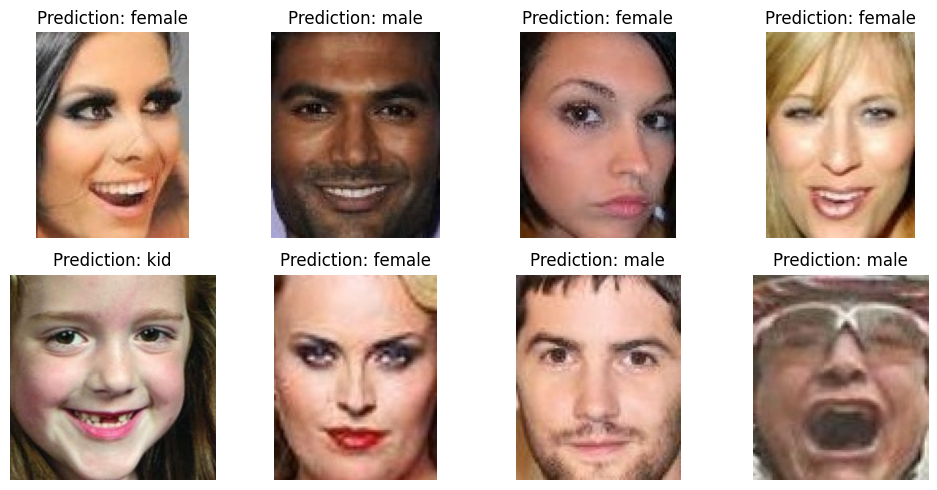

In [74]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.flatten()
for i in range(8):
  img = cv2.imread(test_dataset.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()

In [92]:
# class abc(Dataset):
#     def __init__(self, root, train=False, transform=None):
#         super().__init__()
#         self.image_paths = []
#         self.labels = []
# #         self.categories = ["female", "kid", "male"]
#         self.transform = transform

#         data_path = os.path.join(root, 'test_images')

#         for item in os.listdir(data_path):
#             path = os.path.join(data_path,item)
#             self.image_paths.append(path)
#             self.labels.append(i)

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         image = cv2.imread(image_path)
#         label = self.labels[idx]
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# location = '/kaggle/input/testing'
# testing = abc(root=location, train=False, transform=test_transform)
# print(testing.__len__())




0


IndexError: list index out of range

In [91]:
test_model = VVG16_net().to(device)
test_model.load_state_dict(torch.load('/kaggle/working/last.pt', map_location=torch.device('cpu')))
test_model.eval()

VVG16_net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(


In [89]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
# categories = ["female", "kid", "male"]
indices = random.sample(range(0, testing.__len__()), 6)
print(indices)
images = torch.stack([testing.__getitem__(i)[0] for i in indices])
# images = torch.from_numpy(images)
# print(images)
# # labels = [categories[int(test_dataset.__getitem__(i)[1])] for i in indices]
labels = [test_dataset.__getitem__(i)[1] for i in indices]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the correct device
test_model = test_model.to(device)

# Move images to the same device as the model
images = images.to(device)

# Perform inference and move predictions back to CPU
predictions = torch.argmax(test_model(images).cpu(), dim=1)
print(images.shape)
print(labels)
print(predictions)
#why is this code 

[1, 5, 3, 0, 2, 4]
torch.Size([6, 3, 224, 224])
[0, 0, 0, 0, 0, 0]
tensor([1, 1, 1, 1, 1, 1])


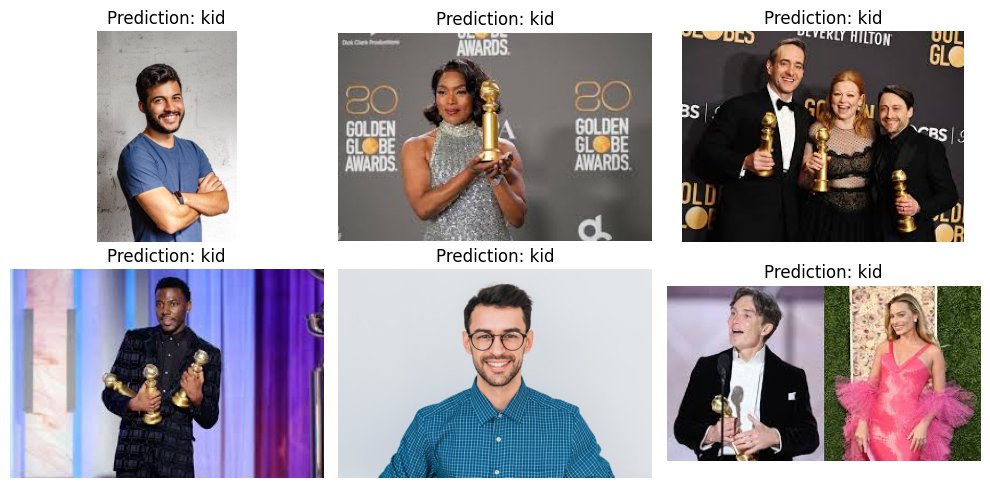

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.flatten()
for i in range(6):
  img = cv2.imread(testing.image_paths[indices[i]])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i].imshow(img)
  title = f"Prediction: {categories[predictions[i]]}"

  # if labels is not None:
  #     title += f"\nTrue Label: {categories[labels[i]]}"

  axes[i].set_title(title)
  axes[i].axis('off')

plt.tight_layout()
plt.show()